In [1]:
import helpers
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score,  balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Integer
from skopt.space import Categorical
from skopt.space import Real
import warnings
import json
warnings.filterwarnings("ignore", category=DeprecationWarning)
'''
In dem Notebook werden noch die Merkmale "HOME_TOTAL_VALUE_JOINING_MIO", "HOME_TOTAL_VALUE_LEAVING_MIO" 
"AWAY_TOTAL_VALUE_JOINING_MIO", "AWAY_TOTAL_VALUE_LEAVING_MIO" mit einbezogen. Die Merkmale stehen erst zu 
einem spätern Zeitpunkt zur Verfügung. Die Ergebnisse sind vergleichbar mit dem Notebook "06_Forecast.ipynb"
und führen zu keinen wesentlichen Verbesserungen.
'''

In [2]:
df = pd.read_pickle("./data/df_merge_club_transfer_data.pkl")
df1 = pd.read_pickle("./data/df_merge_club_transfer_data_with_leave_join_mio_prep1.pkl")
object_columns = df.select_dtypes(include=['object']).columns
RANDOM_STATE = 42
TEST_SIZE_PERCENT = 0.2

In [3]:
df2 = df1.copy()

In [4]:
# Kombinieren die Werte beider Spalten in eine Serie
combined_teams = pd.concat([df2['HOME_TEAM'], df2['AWAY_TEAM']])

# Initialisieren und anpassen Sie den LabelEncoder
le_teams = LabelEncoder()
le_teams.fit(combined_teams)

# Codieren Sie die 'HOME_TEAM' und 'AWAY_TEAM' Spalten
df2['HOME_TEAM'] = le_teams.transform(df2['HOME_TEAM'])
df2['AWAY_TEAM'] = le_teams.transform(df2['AWAY_TEAM'])

# Erstellen ein Mapping-Dictionary für die Decodierung
label_mapping_TEAM = {idx: label for idx, label in enumerate(le_teams.classes_)}

print("Label Mapping:", label_mapping_TEAM)

Label Mapping: {0: '1.FC Kaiserslautern', 1: '1.FC Köln', 2: '1.FC Nürnberg', 3: '1.FC Union Berlin', 4: '1.FSV Mainz 05', 5: 'Arminia Bielefeld', 6: 'Bayer 04 Leverkusen', 7: 'Borussia Dortmund', 8: 'Borussia Mönchengladbach', 9: 'Eintracht Frankfurt', 10: 'FC Augsburg', 11: 'FC Bayern München', 12: 'FC Energie Cottbus', 13: 'FC Ingolstadt 04', 14: 'FC Schalke 04', 15: 'Fortuna Düsseldorf', 16: 'Hamburger SV', 17: 'Hannover 96', 18: 'Hertha BSC', 19: 'RasenBallsport Leipzig', 20: 'SC Freiburg', 21: 'SC Paderborn 07', 22: 'SV Darmstadt 98', 23: 'SV Werder Bremen', 24: 'SpVgg Greuther Fürth', 25: 'TSG 1899 Hoffenheim', 26: 'VfB Stuttgart', 27: 'VfL Bochum', 28: 'VfL Wolfsburg'}


In [5]:
le_REFEREE = LabelEncoder()
encoded_REFEREE = le_REFEREE.fit_transform(df2['REFEREE'])
df2['REFEREE'] = encoded_REFEREE

label_mapping_REFEREE = {idx: label for idx, label in enumerate(le_REFEREE.classes_)}
print("Label Mapping:", label_mapping_REFEREE)

Label Mapping: {0: 'Babak Rafati', 1: 'Bastian Dankert', 2: 'Benjamin Brand', 3: 'Benjamin Cortus', 4: 'Bibiana Steinhaus-Webb', 5: 'Christian Dingert', 6: 'Daniel Schlager', 7: 'Daniel Siebert', 8: 'Deniz Aytekin', 9: 'Dr. Arne Aarnink', 10: 'Dr. Felix Brych', 11: 'Dr. Helmut Fleischer', 12: 'Dr. Jochen Drees', 13: 'Dr. Markus Merk', 14: 'Dr. Martin Thomsen', 15: 'Dr. Matthias Jöllenbeck', 16: 'Dr. Robert Kampka', 17: 'Dr. Robin Braun', 18: 'Felix Zwayer', 19: 'Florian Badstübner', 20: 'Florian Meyer', 21: 'Frank Willenborg', 22: 'Guido Winkmann', 23: 'Günter Perl', 24: 'Harm Osmers', 25: 'Herbert Fandel', 26: 'Knut Kircher', 27: 'Lutz Wagner', 28: 'Manuel Gräfe', 29: 'Marc Seemann', 30: 'Marco Fritz', 31: 'Markus Schmidt', 32: 'Markus Wingenbach', 33: 'Martin Petersen', 34: 'Michael Kempter', 35: 'Michael Weiner', 36: 'Patrick Ittrich', 37: 'Peter Gagelmann', 38: 'Peter Sippel', 39: 'Robert Hartmann', 40: 'Robert Schröder', 41: 'Sascha Stegemann', 42: 'Sven Jablonski', 43: 'Sören Sto

In [6]:
le_RESULT = LabelEncoder()
encoded_RESULT = le_RESULT.fit_transform(df2['RESULT'])
df2['RESULT'] = encoded_RESULT

label_mapping_RESULT = {idx: label for idx, label in enumerate(le_RESULT.classes_)}
print("Label Mapping:", label_mapping_RESULT)

Label Mapping: {0: 'AWAY_WIN', 1: 'DRAW', 2: 'HOME_WIN'}


In [7]:
print(df2[object_columns].iloc[0])

HOME_TEAM                       1.800000e+01
PLACE_HOME_TEAM                 1.400000e+01
AWAY_TEAM                       2.600000e+01
PLACE_AWAY_TEAM                 8.000000e+00
RESULT                          2.000000e+00
REFEREE                         4.400000e+01
HOME_PLAYERS_COUNT              3.600000e+01
HOME_PLAYERS_AVG_AGE            2.450000e+01
HOME_LEGIONARIES_COUNT          2.200000e+01
HOME_AVG_MARKET_VALUE           2.250000e+06
HOME_TOTAL_MARKET_VALUE         8.100000e+07
HOME_AVG_AGE_LEAVING            2.490000e+01
HOME_TOTAL_VALUE_JOINING_MIO    2.250000e-01
HOME_TOTAL_VALUE_LEAVING_MIO    8.750000e-01
HOME_EXPENSES_JOINING_MIO       1.735000e+01
HOME_REVENUE_LEAVING_MIO        1.880000e+01
AWAY_PLAYERS_COUNT              3.500000e+01
AWAY_PLAYERS_AVG_AGE            2.490000e+01
AWAY_LEGIONARIES_COUNT          1.700000e+01
AWAY_AVG_MARKET_VALUE           3.110000e+06
AWAY_TOTAL_MARKET_VALUE         1.088500e+08
AWAY_AVG_AGE_LEAVING            2.610000e+01
AWAY_TOTAL

In [8]:
nan_count = df2.isna().sum()
print(nan_count)
print(len(df))

DATE                             0
WEEKDAY                          0
MONTH                            0
SEASON                           0
MATCHDAY                         0
HOME_TEAM                        0
PLACE_HOME_TEAM                  0
AWAY_TEAM                        0
PLACE_AWAY_TEAM                  0
WIN_PERC_HOME                   92
REMIS_PERC                      92
WIN_PERC_AWAY                   92
HOME_GOALS                       0
AWAY_GOALS                       0
RESULT                           0
REFEREE                          0
HOME_PLAYERS_COUNT               0
HOME_PLAYERS_AVG_AGE             0
HOME_LEGIONARIES_COUNT           0
HOME_AVG_MARKET_VALUE            0
HOME_TOTAL_MARKET_VALUE          0
HOME_AVG_AGE_JOINING             0
HOME_AVG_AGE_LEAVING             0
HOME_TOTAL_VALUE_JOINING_MIO     0
HOME_TOTAL_VALUE_LEAVING_MIO     0
HOME_EXPENSES_JOINING_MIO        0
HOME_REVENUE_LEAVING_MIO         0
AWAY_PLAYERS_COUNT               0
AWAY_PLAYERS_AVG_AGE

In [9]:
selected_features = [
"HOME_TEAM", "PLACE_HOME_TEAM", "HOME_PLAYERS_COUNT", "HOME_PLAYERS_AVG_AGE", "HOME_LEGIONARIES_COUNT",
"HOME_AVG_MARKET_VALUE", "HOME_TOTAL_MARKET_VALUE", "HOME_AVG_AGE_JOINING", "HOME_AVG_AGE_LEAVING", 
"HOME_TOTAL_VALUE_JOINING_MIO","HOME_TOTAL_VALUE_LEAVING_MIO",
"AWAY_TEAM", "PLACE_AWAY_TEAM", "AWAY_PLAYERS_COUNT", "AWAY_PLAYERS_AVG_AGE", "AWAY_LEGIONARIES_COUNT",
"AWAY_AVG_MARKET_VALUE", "AWAY_TOTAL_MARKET_VALUE", "AWAY_AVG_AGE_JOINING", "AWAY_AVG_AGE_LEAVING", 
"AWAY_TOTAL_VALUE_JOINING_MIO", "AWAY_TOTAL_VALUE_LEAVING_MIO",
"MATCHDAY"
]

In [10]:
X = df2[selected_features]
y = df2['RESULT']
# Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENT, shuffle=False)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [11]:
X_test

,HOME_TEAM,PLACE_HOME_TEAM,HOME_PLAYERS_COUNT,HOME_PLAYERS_AVG_AGE,HOME_LEGIONARIES_COUNT,HOME_AVG_MARKET_VALUE,HOME_TOTAL_MARKET_VALUE,HOME_AVG_AGE_JOINING,HOME_AVG_AGE_LEAVING,HOME_TOTAL_VALUE_JOINING_MIO,...,AWAY_PLAYERS_COUNT,AWAY_PLAYERS_AVG_AGE,AWAY_LEGIONARIES_COUNT,AWAY_AVG_MARKET_VALUE,AWAY_TOTAL_MARKET_VALUE,AWAY_AVG_AGE_JOINING,AWAY_AVG_AGE_LEAVING,AWAY_TOTAL_VALUE_JOINING_MIO,AWAY_TOTAL_VALUE_LEAVING_MIO,MATCHDAY
0,19,4,32,23.7,23,17970000.0,574950000.0,20.8,20.8,132.05,...,33,24.9,15,1720000.0,56730000.0,22.3,24.8,36.00,17.28,9
1,3,5,33,25.8,10,2490000.0,82050000.0,23.7,24.9,95.15,...,36,25.6,24,7480000.0,269150000.0,22.0,26.6,58.60,55.93,9
2,10,10,31,25.8,19,3000000.0,93050000.0,25.1,25.2,50.50,...,30,25.2,13,4640000.0,139100000.0,24.0,25.7,45.25,68.75,9
3,26,8,32,23.8,16,5910000.0,189250000.0,22.0,24.6,87.78,...,45,23.9,22,19070000.0,858230000.0,22.8,24.2,232.10,66.00,9
4,6,3,33,25.0,22,11310000.0,373250000.0,21.6,24.6,185.30,...,38,24.4,21,6020000.0,228880000.0,22.6,25.1,78.25,36.00,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,8,11,35,25.4,16,6910000.0,241680000.0,22.1,23.8,45.55,...,42,25.0,23,3150000.0,132280000.0,22.6,24.6,69.20,39.50,34
748,9,8,36,25.0,22,9020000.0,324550000.0,22.6,24.2,157.75,...,29,26.0,11,6930000.0,200950000.0,23.3,23.1,59.75,92.15,34
749,28,7,33,24.7,20,7220000.0,238300000.0,22.3,24.6,78.60,...,41,25.4,21,2290000.0,94000000.0,23.7,24.4,84.83,80.78,34
750,27,16,32,27.7,18,1680000.0,53700000.0,25.4,26.0,26.80,...,35,24.2,24,12930000.0,452550000.0,21.8,24.6,55.85,27.65,34


## RandomForestClassifier

In [12]:
warnings.filterwarnings("ignore", category=UserWarning, message=".*Precision and F-score are ill-defined.*") 
warnings.filterwarnings("ignore", category=UserWarning, message=".*The objective has been evaluated at this point before.*") 
search_space = {
    'n_estimators': Integer(10, 300),          # Ganzzahlige Variable
    'max_depth': Integer(3, 10),               # Ganzzahlige Variable
    'criterion': Categorical(['gini', 'entropy']),  # Kategorische Variable
    'class_weight': Categorical([None, 'balanced']),  # Keine Klassengewichtung, Automatische Klassengweichtung
    'max_features': Real(0.1, 0.999, prior='uniform')  # Reelle Variable
    # 'min_samples_split': Integer(2, 20),
    # 'min_samples_leaf': Integer(1, 20),
}

# Bayes'sche Optimierung
opt_rmforest = BayesSearchCV(
    RandomForestClassifier(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=50,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_rmforest.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_rmforest.best_params_)

Best parameters found: OrderedDict([('class_weight', None), ('criterion', 'entropy'), ('max_depth', 8), ('max_features', 0.1), ('n_estimators', 300)])


In [13]:
model_name = 'random_forest'
result = helpers.get_model_forecast_results(opt_rmforest, X_test, y_test, le_teams, is_optimizer=True)
with open(f'./resultsLeaveJoinMio/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.523936170212766
Balanced Accuracy: 0.43976791829817774

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49       220
           1       0.20      0.01      0.01       185
           2       0.55      0.82      0.66       347

    accuracy                           0.52       752
   macro avg       0.41      0.44      0.38       752
weighted avg       0.44      0.52      0.45       752



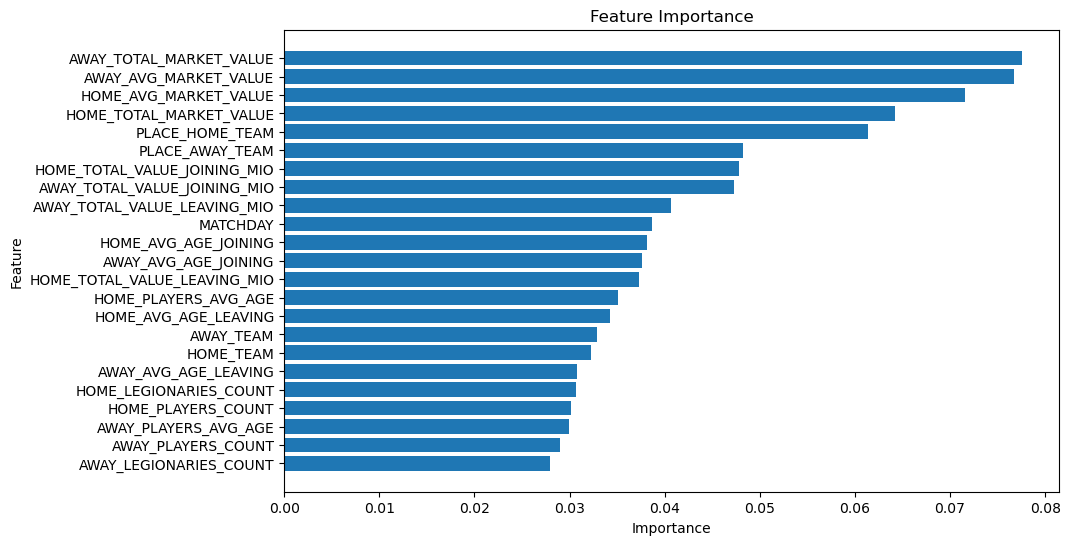

In [14]:
best_model = opt_rmforest.best_estimator_

# Feature-Importance auslesen
feature_importance = best_model.feature_importances_

feature_names = X.columns.tolist()  # Ersetzen Sie dies durch die echten Feature-Namen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

feature_importance_df.sort_values(by='Importance', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## KNeighborsClassifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")
search_space = {
  'n_neighbors': Integer(1, 30),
    'weights': Categorical(['uniform', 'distance']),
    'metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
    'p': Integer(1, 6),
    'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute'])
}

# Bayes'sche Optimierung
opt_knn = BayesSearchCV(
    KNeighborsClassifier(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=40,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_knn.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_knn.best_params_)

Best parameters found: OrderedDict([('algorithm', 'auto'), ('metric', 'manhattan'), ('n_neighbors', 30), ('p', 6), ('weights', 'uniform')])


In [16]:
model_name = 'kneighbors'
result = helpers.get_model_forecast_results(opt_knn, X_test, y_test, le_teams, is_optimizer=True)
with open(f'./resultsLeaveJoinMio/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.49867021276595747
Balanced Accuracy: 0.42627670898564274

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.50      0.46       220
           1       0.24      0.03      0.06       185
           2       0.55      0.75      0.64       347

    accuracy                           0.50       752
   macro avg       0.41      0.43      0.38       752
weighted avg       0.44      0.50      0.44       752



## MultinomialNB

In [17]:
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings("ignore", message="`np.int` is a deprecated alias for the builtin `int`")
search_space = {
    'alpha': Real(0, 1, prior='uniform'),  # oder auch Integer, wenn Sie diskrete Werte möchten
    'fit_prior': Categorical([True, False])
}

# Bayes'sche Optimierung
opt_mnb = BayesSearchCV(
    MultinomialNB(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=40,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_mnb.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_mnb.best_params_)

Best parameters found: OrderedDict([('alpha', 0.5676795952345629), ('fit_prior', True)])


In [18]:
model_name = 'multinominalNB'
result = helpers.get_model_forecast_results(opt_mnb, X_test, y_test, le_teams, is_optimizer=True)
with open(f'./resultsLeaveJoinMio/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.4800531914893617
Balanced Accuracy: 0.44297948721579844

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.60      0.50       220
           1       0.25      0.15      0.19       185
           2       0.61      0.58      0.59       347

    accuracy                           0.48       752
   macro avg       0.43      0.44      0.43       752
weighted avg       0.47      0.48      0.47       752



## GaussianNB

In [19]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [20]:
model_name = 'gaussian_naive_bayes'
result = helpers.get_model_forecast_results(gnb, X_test, y_test, le_teams, is_optimizer=False)
with open(f'./resultsLeaveJoinMio/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.5199468085106383
Balanced Accuracy: 0.4410357174045935

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.54      0.50       220
           1       0.00      0.00      0.00       185
           2       0.55      0.79      0.65       347

    accuracy                           0.52       752
   macro avg       0.34      0.44      0.38       752
weighted avg       0.39      0.52      0.44       752



## QuadraticDiscriminantAnalysis

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
warnings.filterwarnings("ignore", message="`np.int` is a deprecated alias for the builtin `int`")
search_space = {
    'tol': Real(1e-4,  1e-2, prior='uniform'),  # Annahme von 2 Klassen
    'reg_param': Real(0, 1, prior='uniform'),
    'store_covariance': Categorical([True, False])
}
# Bayes'sche Optimierung
opt_qda = BayesSearchCV(
    QuadraticDiscriminantAnalysis(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=40,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_qda.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_qda.best_params_)

Best parameters found: OrderedDict([('reg_param', 0.902905207839295), ('store_covariance', False), ('tol', 0.009703849384295677)])


In [22]:
model_name = 'quadratic_discriminant_analysis'
result = helpers.get_model_forecast_results(opt_qda, X_test, y_test, le_teams, is_optimizer=False)
with open(f'./resultsLeaveJoinMio/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.46808510638297873
Balanced Accuracy: 0.4410259224380262

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.62      0.49       220
           1       0.26      0.17      0.21       185
           2       0.63      0.53      0.57       347

    accuracy                           0.47       752
   macro avg       0.43      0.44      0.42       752
weighted avg       0.47      0.47      0.46       752

